In [1]:
import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, r2_score

from catboost import CatBoostRegressor, CatBoostClassifier

import nltk

# Домашняя работа

Работаем с отзывами на авиа-компанию:

https://www.kaggle.com/datasets/kanchana1990/singapore-airlines-reviews/data


In [2]:
df = pd.read_csv('../data/singapore_airlines_reviews.csv')
df = df[['rating', 'text', 'title']]
df.head()

,rating,text,title
0,3,We used this airline to go from Singapore to L...,Ok
1,5,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...
2,1,"Booked, paid and received email confirmation f...",Don’t give them your money
3,5,"Best airline in the world, seats, food, servic...",Best Airline in the World
4,2,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...




## Easy

Выбрать метрику.

Удалить пунктуацию из датасета.

Преобразовать датасет в BOW или TF-IDF, поделить на треин-тест и спрогнозировать вашей любимой моделью


In [3]:
def pre_process(text):
    text = text.lower()
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = ' '.join(text.split())
    return text

df['text'] = df['text'].apply(str).apply(pre_process)
df['title'] = df['title'].apply(str).apply(pre_process)
df.head()

,rating,text,title
0,3,we used this airline to go from singapore to l...,ok
1,5,the service on singapore airlines suites class...,the service in suites class makes one feel lik...
2,1,booked paid and received email confirmation fo...,don’t give them your money
3,5,best airline in the world seats food service a...,best airline in the world
4,2,premium economy seating on singapore airlines ...,premium economy seating on singapore airlines ...


In [4]:
# можно было бы сделать ансабль моделей для оценки текста и заголовка по отдельности, но видимо задание этого не подразумевает, поэтому просто соединим
df['text'] = df['title'] + ' ' + df['text']
df = df[['rating', 'text']]

In [5]:
x_train_raw, x_test_raw, y_train, y_test = train_test_split(df['text'], df['rating'], train_size=0.8, random_state=113)
 
tfid = TfidfVectorizer()
x_train = tfid.fit_transform(x_train_raw).toarray()
x_test = tfid.transform(x_test_raw).toarray()

Text(0.5, 0, 'rating')

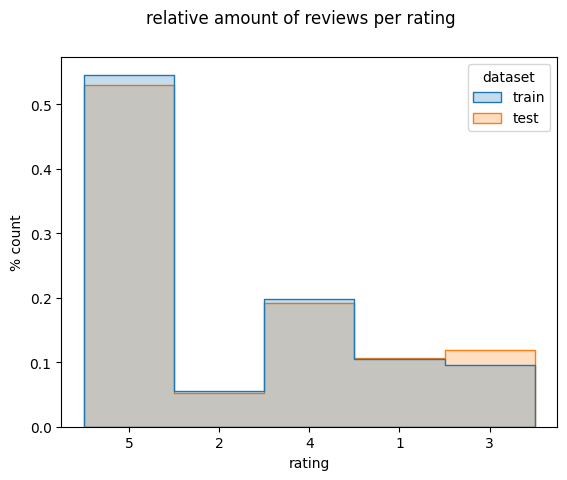

In [6]:
plt.suptitle('relative amount of reviews per rating')

df_extra = pd.concat([
    pd.DataFrame({'rating': y_train.astype(str), 'dataset': 'train'}),
    pd.DataFrame({'rating': y_test.astype(str), 'dataset': 'test'})
])

sns.histplot(
    df_extra,
    x='rating',
    hue='dataset',
    element="step",
    stat='density',
    common_norm=False
)

plt.ylabel('% count')
plt.xlabel('rating')

Классы несбалансированны, поэтому как и в задаче со знаками будем использовать f1 + LogReg (показалаа себя очень хорошо).

In [7]:
max_iter = 50
n_jobs = 12

In [8]:
%%time

model_LR = LogisticRegression(max_iter=max_iter, n_jobs=n_jobs, random_state=113)
model_LR.fit(x_train, y_train)

CPU times: total: 1.14 s
Wall time: 17.9 s


LogisticRegression(max_iter=50, n_jobs=12, random_state=113)

In [9]:
def show_model_perfection_metrics(y_test, y_pred):
    print('F1: ', f1_score(y_test, y_pred, average='weighted'))
    print('R2: ', r2_score(y_test, y_pred))

    plt.figure(figsize=(16, 16))
    sns.histplot(y_test - y_pred, kde=True)
    plt.xlabel('Error')
    plt.ylabel('Count')
    plt.show()

F1:  0.6512139671797964
R2:  0.5510433982223077


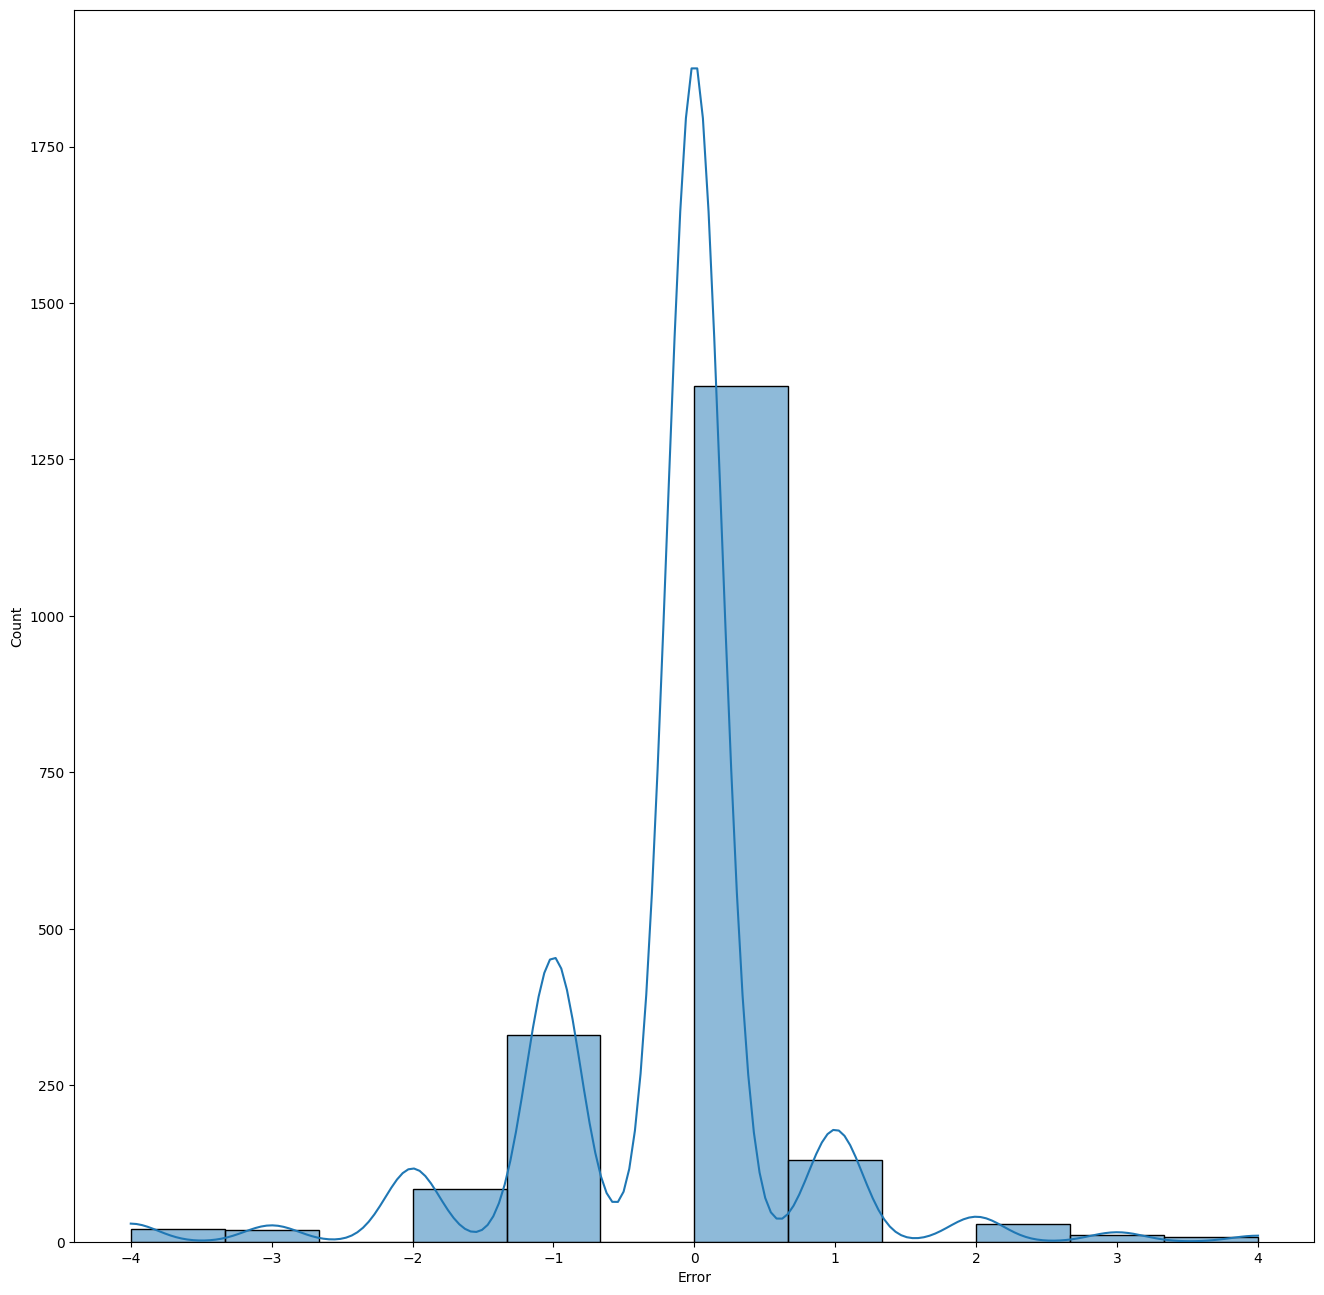

In [10]:
show_model_perfection_metrics(y_test, model_LR.predict(x_test))

Как и ожидалось, модель склонна к завышению оценки (ибо положительные отзывы - это самый мощный класс).


## Normal

Удалить стоп-слова, применить стемминг/лемматизацию. Обучить несколько моделей, подобрать параметры, сделать выводы.

Написать самостоятельно два отзыва - один положительный, один негативный, посмотреть, угадает ли модель.

In [11]:
nltk.download('wordnet')
nltk.download("omw-1.4")

lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize(word):
    word = lemmatizer.lemmatize(word, pos="v")
    word = lemmatizer.lemmatize(word, pos="a")
    word = lemmatizer.lemmatize(word, pos="r")
    word = lemmatizer.lemmatize(word, pos="n")
    return word

def remorph(text):
    return ' '.join([lemmatize(word) for word in text.split()])

df['text'] = df['text'].apply(remorph)
df.head()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\setday\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\setday\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,rating,text
0,3,ok we use this airline to go from singapore to...
1,5,the service in suit class make one feel like v...
2,1,don’t give them your money book pay and receiv...
3,5,best airline in the world best airline in the ...
4,2,premium economy seat on singapore airline not ...


In [12]:
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

df['text'] = df['text'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\setday\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,rating,text
0,3,ok use airline go singapore london heathrow is...
1,5,service suit class make one feel like vip serv...
2,1,don’t give money book pay receive email confir...
3,5,best airline world best airline world seat foo...
4,2,premium economy seat singapore airline worth m...


In [13]:
x_train_raw, x_test_raw, y_train, y_test = train_test_split(df['text'], df['rating'], train_size=0.8, random_state=113)
 
tfid = TfidfVectorizer()
x_train = tfid.fit_transform(x_train_raw).toarray()
x_test = tfid.transform(x_test_raw).toarray()

y_train_float = y_train.astype(float)
y_test_float = y_test.astype(float)

F1:  0.6408549034833019
R2:  0.5496696020112377


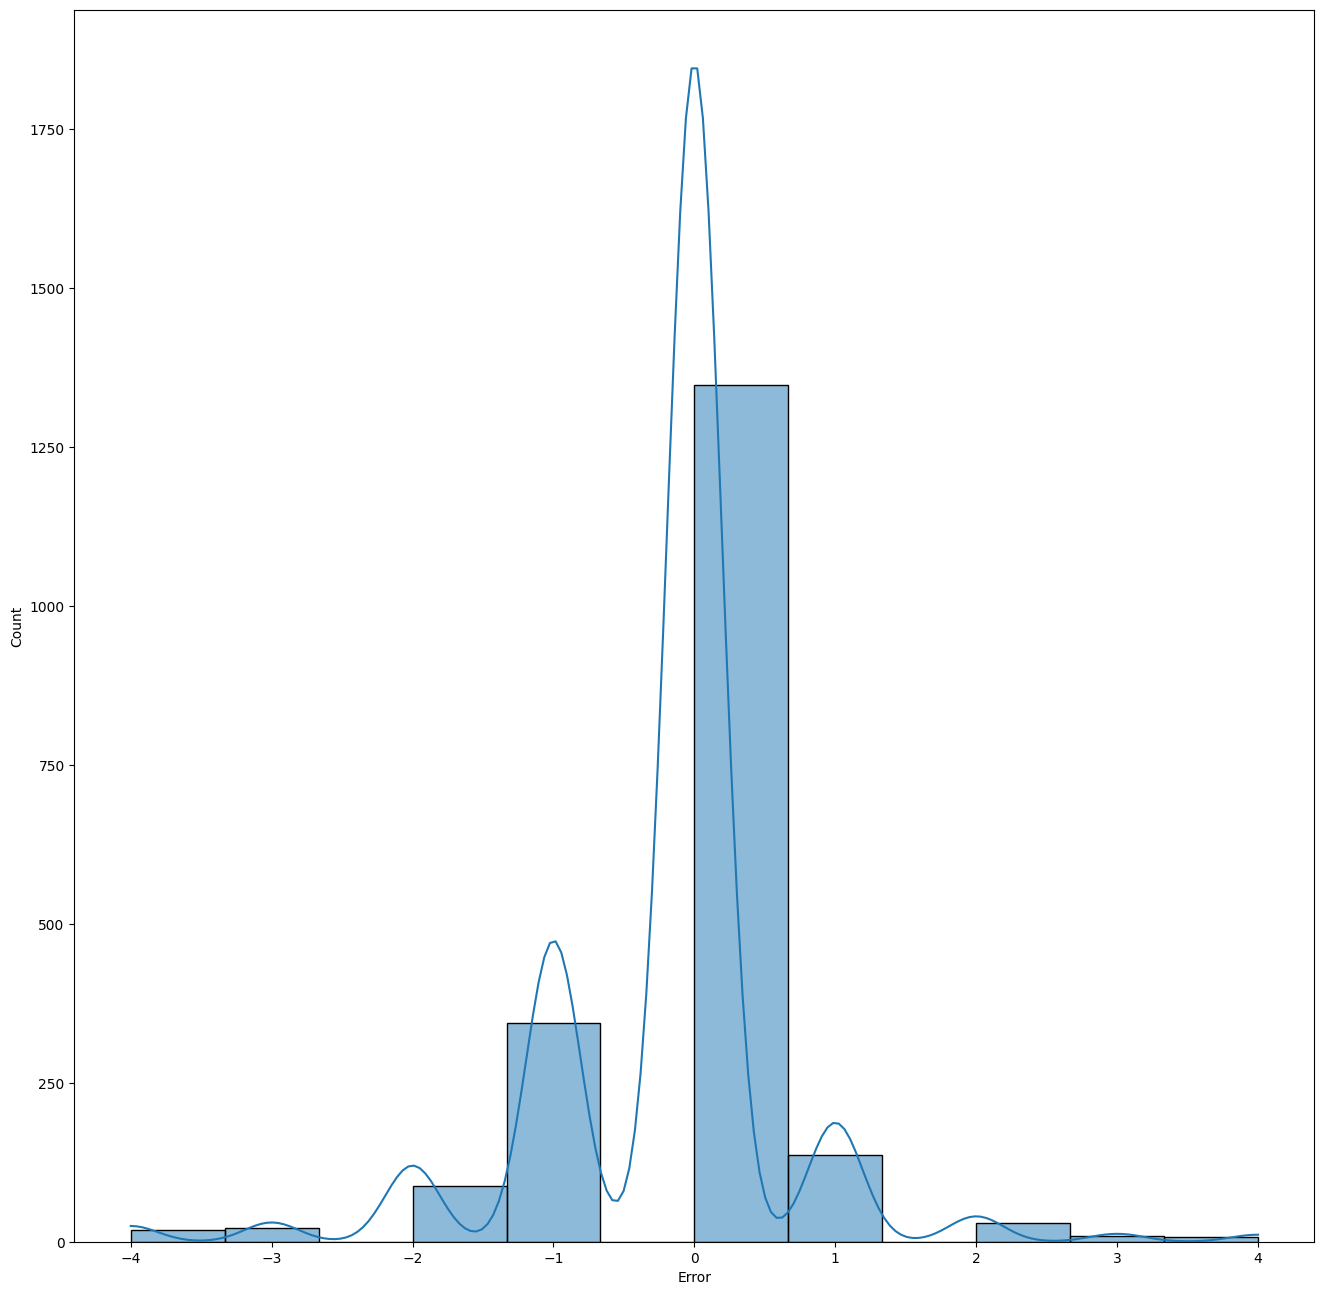

CPU times: total: 906 ms
Wall time: 14.5 s


In [14]:
%%time

model_LR = LogisticRegression(max_iter=max_iter, n_jobs=n_jobs, random_state=113)
model_LR.fit(x_train, y_train)

show_model_perfection_metrics(y_test, model_LR.predict(x_test))

F1:  0.6516928478562304
R2:  0.5477462873157396


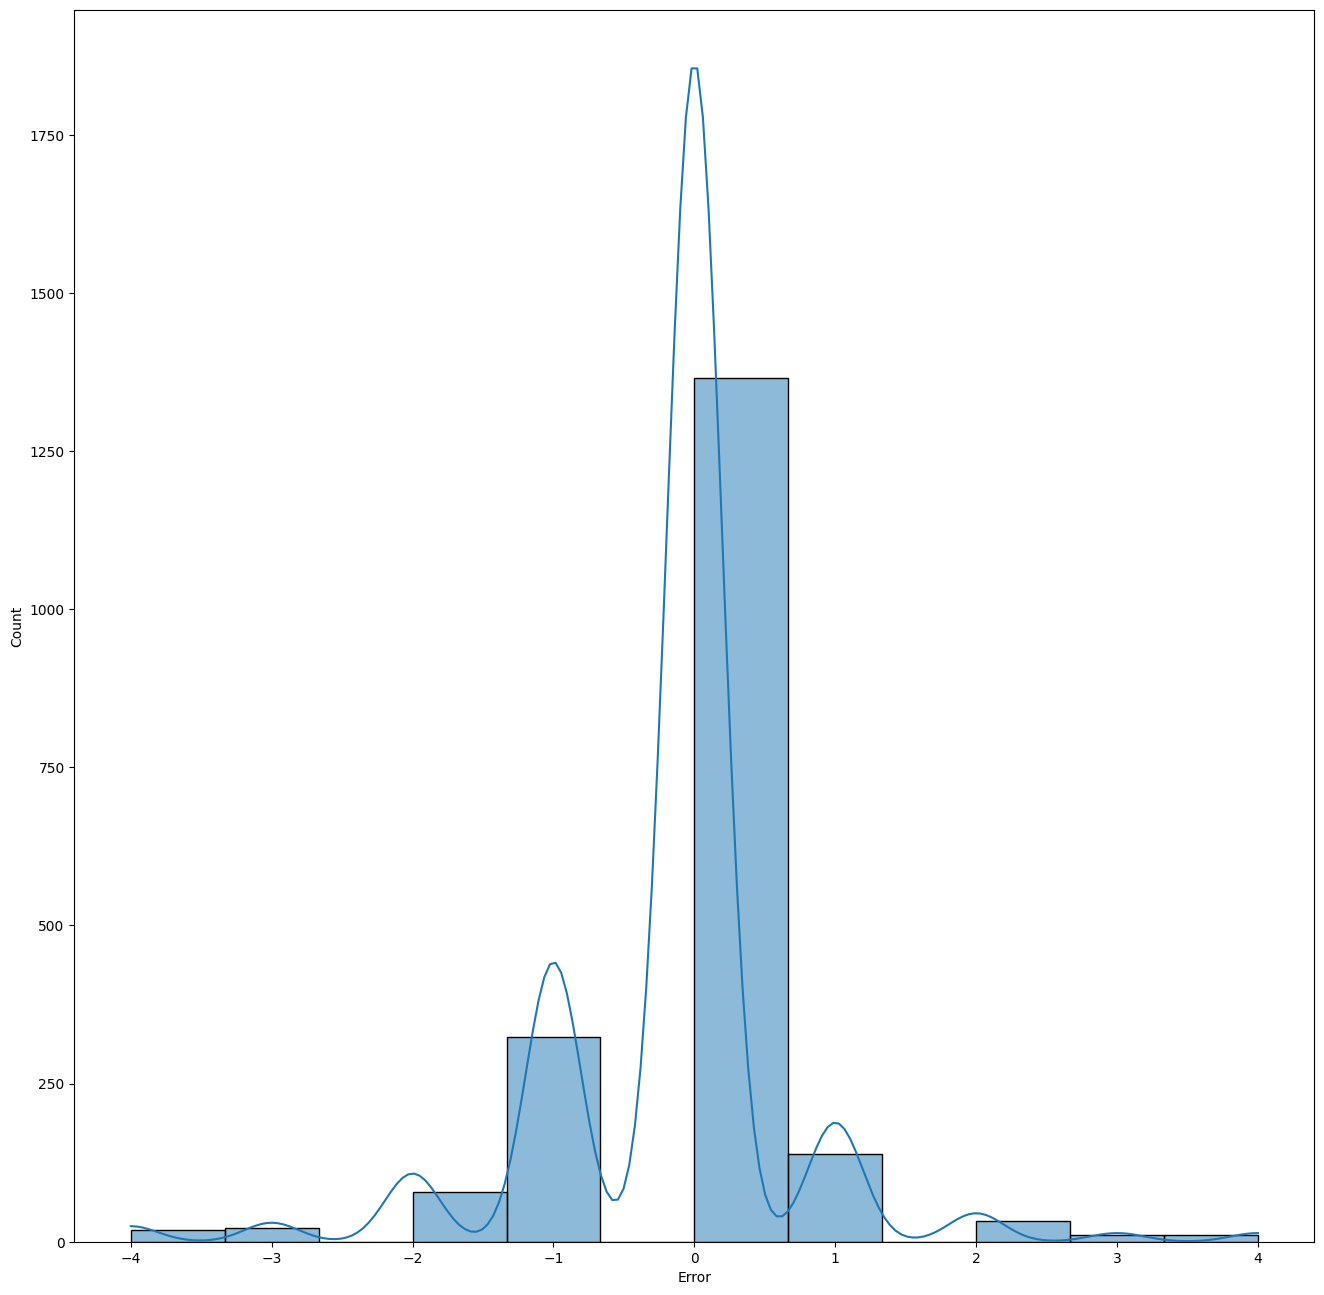

CPU times: total: 4.83 s
Wall time: 4.84 s


In [21]:
%%time

model_CB = CatBoostClassifier(iterations=(max_iter*50), loss_function='MultiClass', random_seed=113, task_type='GPU', verbose=False)
model_CB.fit(
    x_train, y_train,
    eval_set=(x_test, y_test),
)

pred = model_CB.predict(x_test)
pred = np.array([p[0] for p in pred])
show_model_perfection_metrics(y_test, pred)

F1:  0.5659640307626786
R2:  0.23177315876962812


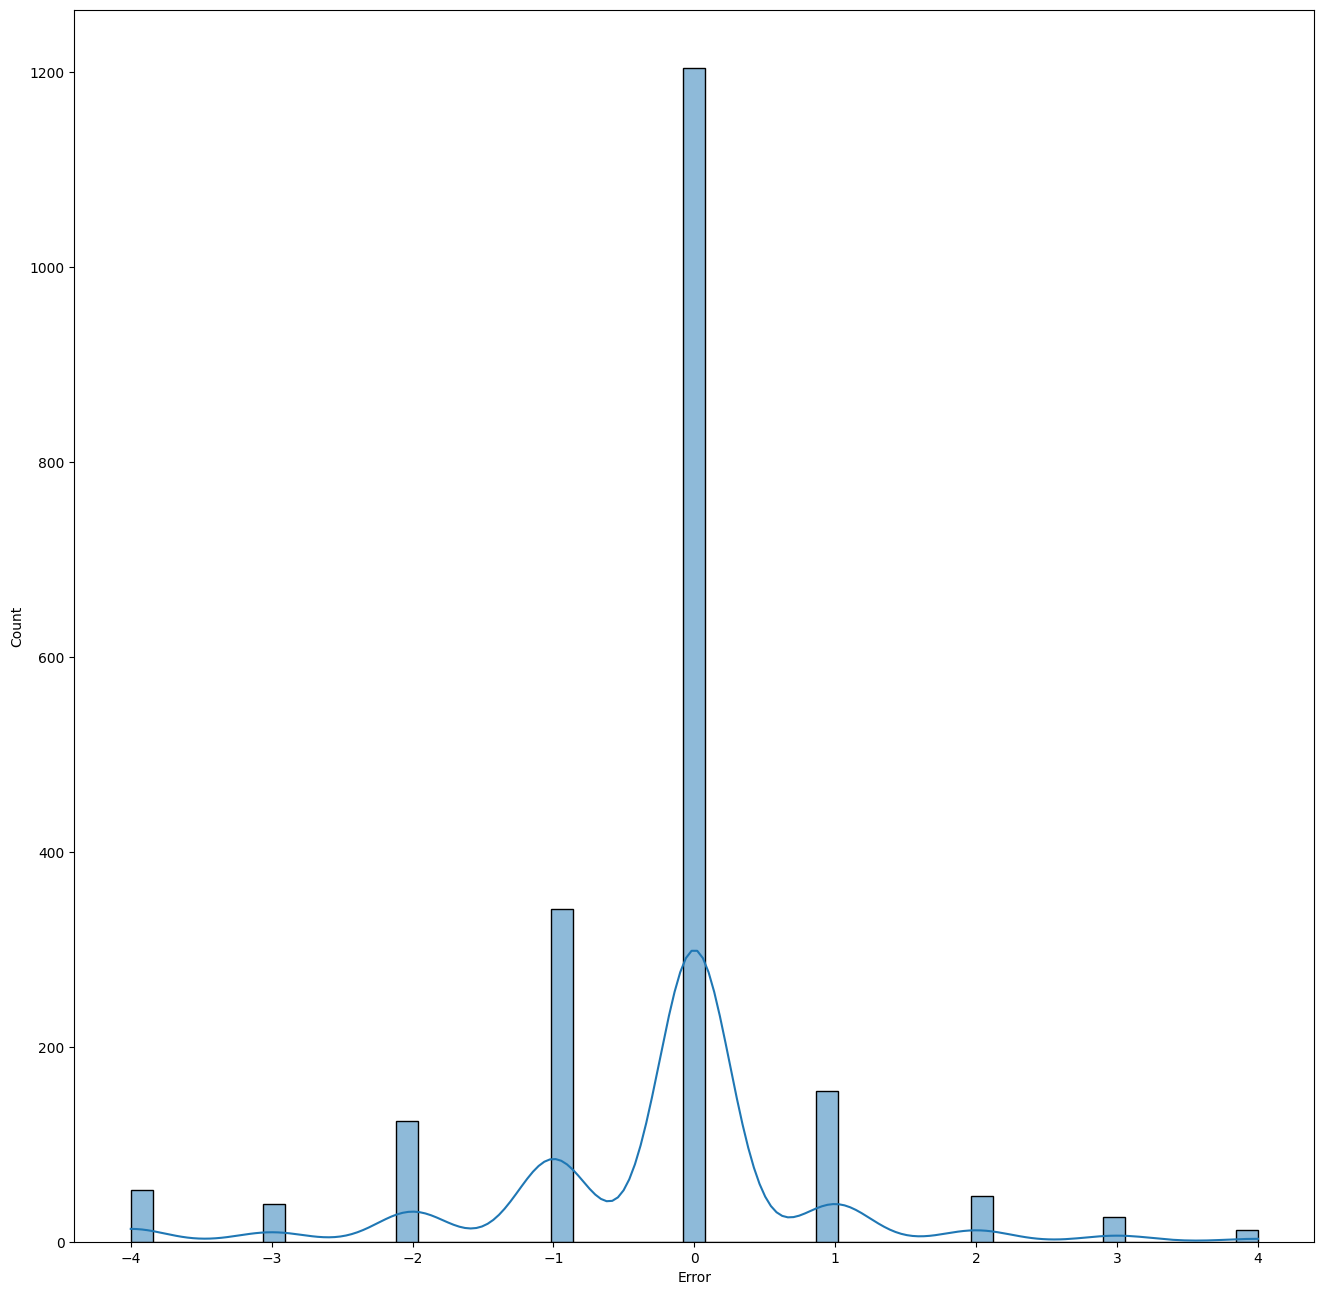

CPU times: total: 25.9 s
Wall time: 3.11 s


In [16]:
%%time

model_knn = KNeighborsClassifier(n_neighbors=6)
model_knn.fit(x_train, y_train)

show_model_perfection_metrics(y_test, model_knn.predict(x_test))

F1:  0.5297005348512364
R2:  0.17407371790468606


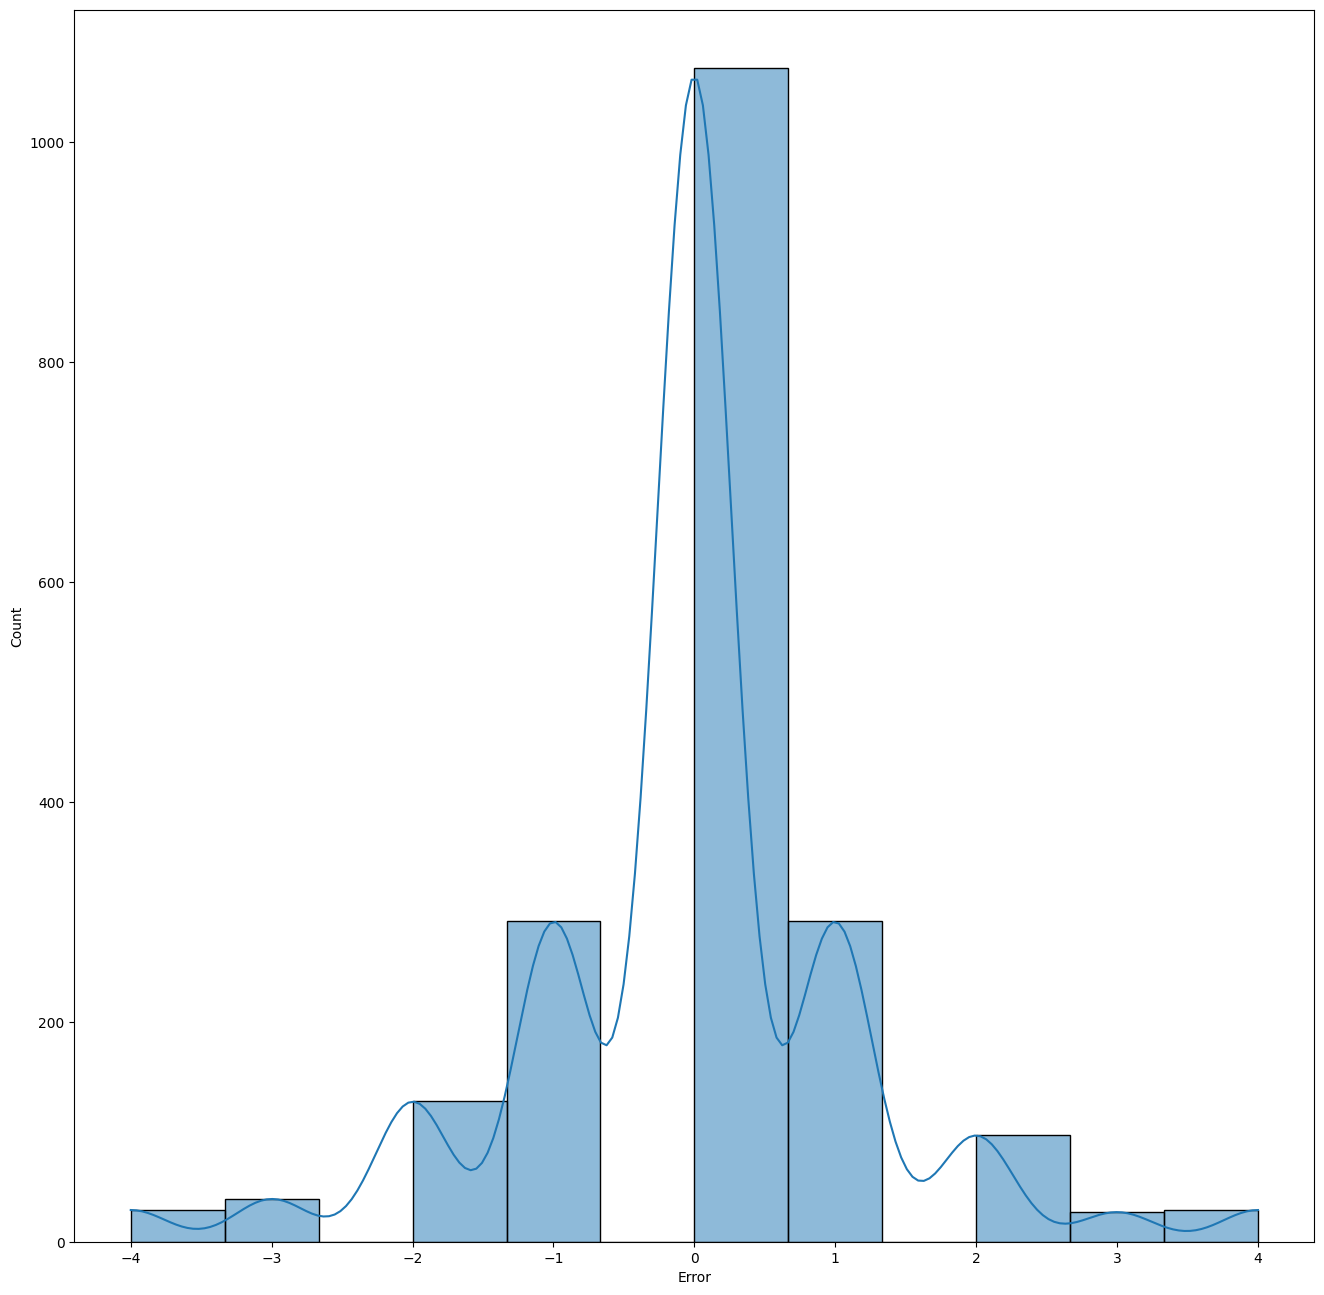

CPU times: total: 15.2 s
Wall time: 15.8 s


In [17]:
%%time

model_DT = DecisionTreeClassifier(max_depth=100, random_state=113)
model_DT.fit(x_train, y_train)

show_model_perfection_metrics(y_test, model_DT.predict(x_test))

C:\Users\setday\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


F1:  0.46038865779891375
R2:  0.1603357557939855


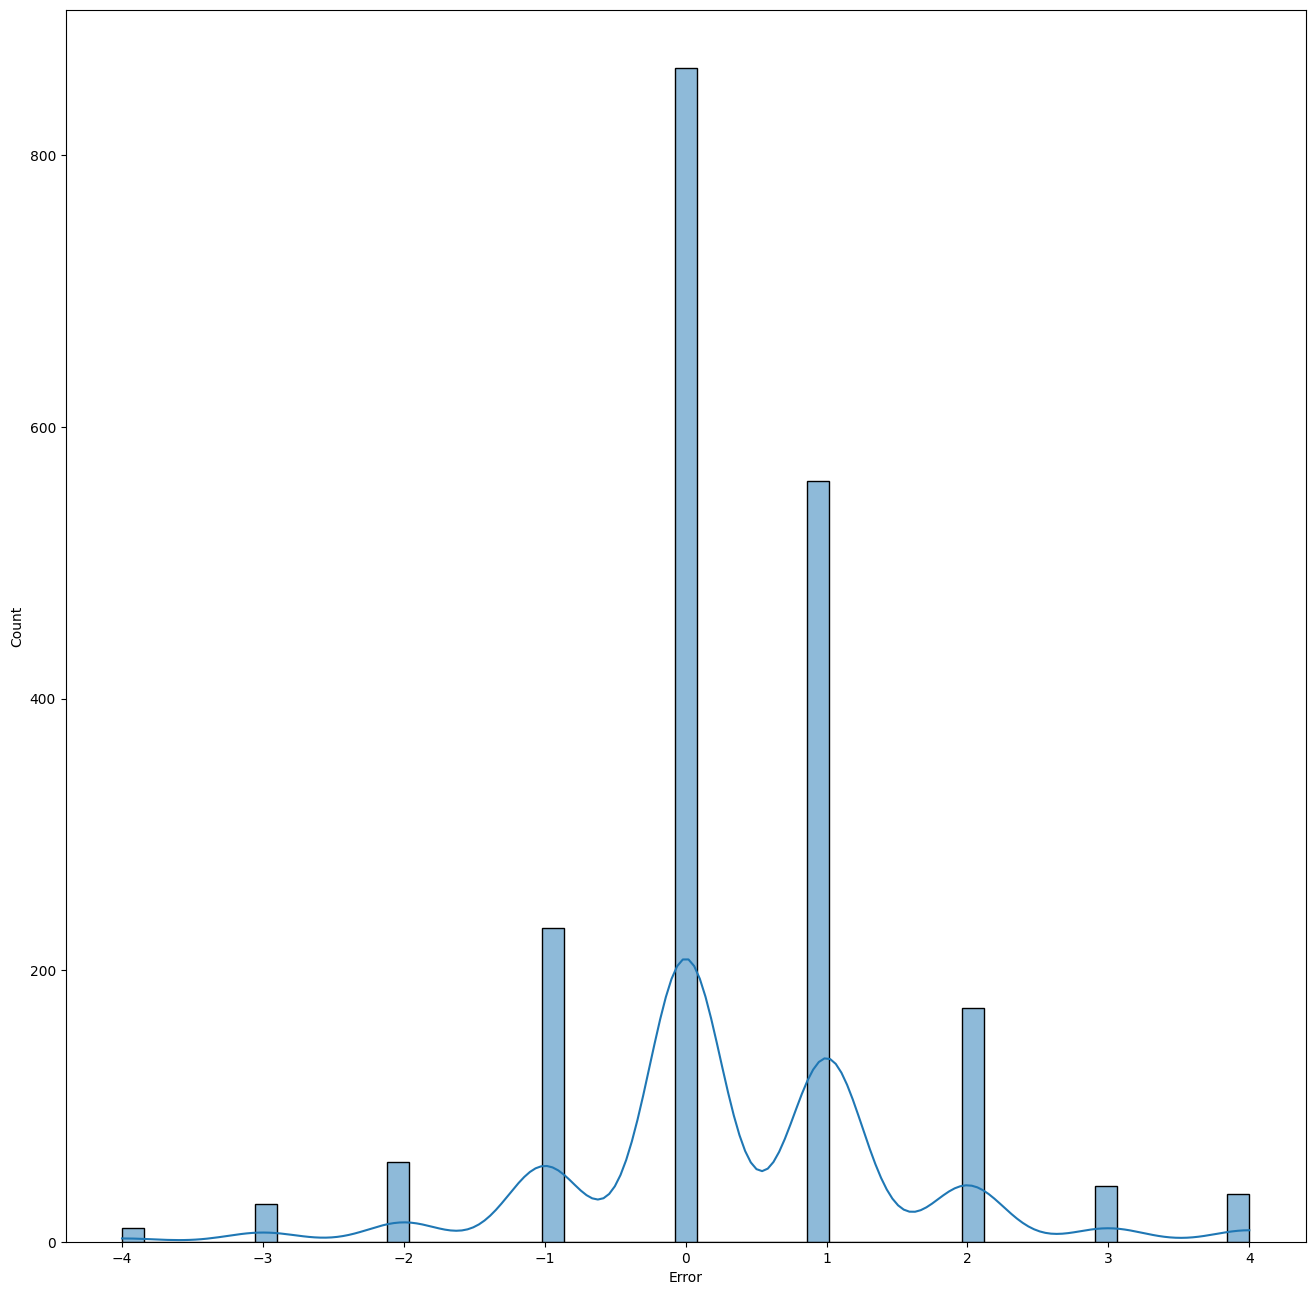

CPU times: total: 7min 34s
Wall time: 9min 11s


In [18]:
%%time

model_SVM = SVC(kernel='rbf', max_iter=max_iter, cache_size=4000, random_state=113)
model_SVM.fit(x_train, y_train)

show_model_perfection_metrics(y_test, model_SVM.predict(x_test))

Лучше всего себя показали `CatBoost` и `LogReg`. Подберём параметры для `CatBoost`.

In [ ]:
%%time

best_params = None
best_score = 0
best_model = None

for depth in [10, 20]:
    for learning_rate in [None, 0.04, 0.05]:
        for l2_leaf_reg in [None, 1, 0.2, 2]:
            model_CB_P = CatBoostClassifier(
                iterations=(max_iter*20),
                loss_function='MultiClass',
                random_seed=113,
                verbose=False,
                task_type='GPU',

                learning_rate=learning_rate,
                depth=depth,
                l2_leaf_reg=l2_leaf_reg,
            )
            model_CB_P.fit(
                x_train, y_train,
                eval_set=(x_test, y_test),
            )

            y_pred = model_CB_P.predict(x_test)
            f1_prec = f1_score(y_test, y_pred, average='weighted')

            print(f'depth: {depth}, learning_rate: {learning_rate}, l2_leaf_reg: {l2_leaf_reg} | f1: {f1_prec}')

            if f1_prec > best_score:
                best_params = {'depth': depth, 'learning_rate': learning_rate, 'l2_leaf_reg': l2_leaf_reg}
                best_model = CatBoostClassifier(
                    iterations=(max_iter*50),
                    loss_function='MultiClass',
                    random_seed=113,
                    verbose=False,
                    task_type='GPU',

                    learning_rate=learning_rate,
                    depth=depth,
                    l2_leaf_reg=l2_leaf_reg,
                )
                best_score = f1_prec

print(best_params, best_score)

depth: 10, learning_rate: None, l2_leaf_reg: None | f1: 0.639156933519463
depth: 10, learning_rate: None, l2_leaf_reg: 1 | f1: 0.6364097616010387
depth: 10, learning_rate: None, l2_leaf_reg: 0.2 | f1: 0.6360443172200841


KeyboardInterrupt: 

Exception ignored in: '_catboost._py_target_type_to_raw_target_data'
Traceback (most recent call last):
  File "c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\numerictypes.py", line 416, in issubdtype
    if not issubclass_(arg1, generic):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\numerictypes.py", line 283, in issubclass_
    @set_module('numpy')
    
KeyboardInterrupt: 


: 

Запускал частями, поэтому `output` небольшой. Вот полная версия:

```
depth: None, learning_rate: None, l2_leaf_reg: None | f1: 0.6442035554468285
depth: None, learning_rate: None, l2_leaf_reg: 1 | f1: 0.6325720729674049
depth: None, learning_rate: None, l2_leaf_reg: 0.1 | f1: 0.6344229749193577
depth: None, learning_rate: None, l2_leaf_reg: 10 | f1: 0.6207781314914439
depth: None, learning_rate: 0.02, l2_leaf_reg: None | f1: 0.6195773405598823
depth: None, learning_rate: 0.02, l2_leaf_reg: 1 | f1: 0.621042001942782
depth: None, learning_rate: 0.02, l2_leaf_reg: 0.1 | f1: 0.6223882516728378
depth: None, learning_rate: 0.02, l2_leaf_reg: 10 | f1: 0.6187811750690064
depth: None, learning_rate: 0.03, l2_leaf_reg: None | f1: 0.6277054336806596
depth: None, learning_rate: 0.03, l2_leaf_reg: 1 | f1: 0.6325720729674049
depth: None, learning_rate: 0.03, l2_leaf_reg: 0.1 | f1: 0.6344229749193577
depth: None, learning_rate: 0.03, l2_leaf_reg: 10 | f1: 0.6207781314914439
depth: None, learning_rate: 0.04, l2_leaf_reg: None | f1: 0.6304918670571669
depth: None, learning_rate: 0.04, l2_leaf_reg: 1 | f1: 0.6334635284750875
depth: None, learning_rate: 0.04, l2_leaf_reg: 0.1 | f1: 0.6344107016060334
depth: None, learning_rate: 0.04, l2_leaf_reg: 10 | f1: 0.6248982043065892
depth: 10, learning_rate: None, l2_leaf_reg: None | f1: 0.639156933519463
depth: 10, learning_rate: None, l2_leaf_reg: 1 | f1: 0.6364097616010387
depth: 10, learning_rate: None, l2_leaf_reg: 0.1 | f1: 0.6354610442817207
depth: 10, learning_rate: None, l2_leaf_reg: 10 | f1: 0.6292142580494205
depth: 10, learning_rate: 0.02, l2_leaf_reg: None | f1: 0.6314433451582298
depth: 10, learning_rate: 0.02, l2_leaf_reg: 1 | f1: 0.6308013297765119
depth: 10, learning_rate: 0.02, l2_leaf_reg: 0.1 | f1: 0.628414392333968
depth: 10, learning_rate: 0.02, l2_leaf_reg: 10 | f1: 0.6262104521021441
depth: 10, learning_rate: 0.03, l2_leaf_reg: None | f1: 0.6366428430528716

depth: 10, learning_rate: None, l2_leaf_reg: None | f1: 0.639156933519463
depth: 10, learning_rate: None, l2_leaf_reg: 1 | f1: 0.6364097616010387
```

F1:  0.6516928478562304
R2:  0.5477462873157396


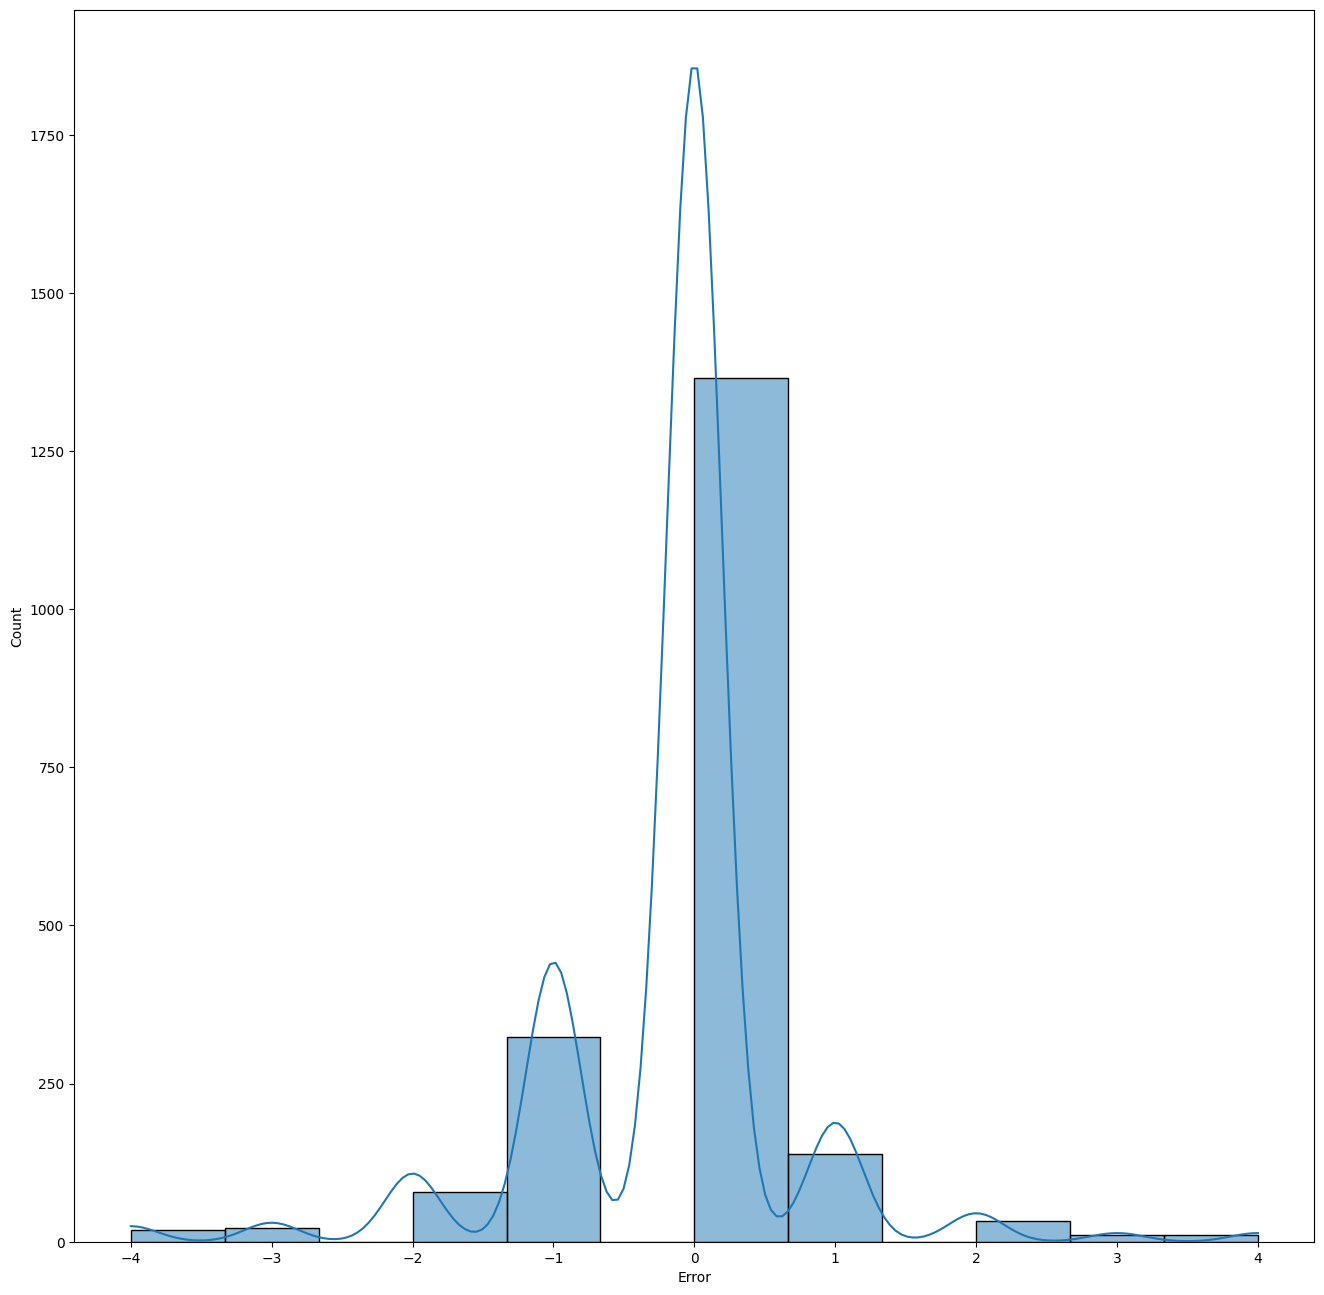

In [20]:
model = best_model
model.fit(
    x_train, y_train,
    eval_set=(x_test, y_test),
)

pred = model.predict(x_test)
pred = np.array([p[0] for p in pred])
show_model_perfection_metrics(y_test, pred)

In [57]:
my_reviews = [{
    'text' : 'I realy love the flight. There was no turbulence, seats were comfortable. This is definitely the best airline in the world. I will definitely fly with them again.',
    'title' : 'Best airline in the world',
    'rating' : 5
},
{
    'text' : 'I hate this airline. The flight was delayed, the seats were very narrow. But even worse attitude to the luggage. It was completely broken.',
    'title' : 'Bad airplanes with bad service',
    'rating' : 1
},
{
    'text' : 'Nothing special. The flight was normal. The choice of snacks was quite poor, but for such a short flight it is not critical. There was an advertising on every luggage compartment, but for this price it is quite normal.',
    'title' : 'Just a normal flight',
    'rating' : 3
}]

def prefactoring(text, title):
    text = title + ' ' + text
    text = pre_process(text)
    text = remorph(text)
    text = remove_stopwords(text)
    return text

prefactored_reviews = [prefactoring(review['text'], review['title']) for review in my_reviews]
x_my_reviews = tfid.transform(prefactored_reviews).toarray()

pred = model.predict(x_my_reviews)
print(pred)
print([review['rating'] for review in my_reviews])

[[5]
 [1]
 [3]]
[5, 1, 3]


Хм, довольно аккуратно.


## Hard

Исследовать какие слова полученный алгоритм воспринимает как резко-негативные и резко-позитивные. Научиться систематически обманывать классификатор. Написать 5 положительных и 5 негативных отзывов, где модель будет ошибаться. Важен алгоритм по которому вы составляете эти отзывы, а не сами отзывы.

In [60]:
my_reviews = [
{
    'text' : 'Other companies are terrible: long flight delayes, poor entertament system, the unwillingness of stewards to help in different situations (even in the simplest ones) is striking. But Singapore Airlines is devoid of these disadvantages. Of course, there is space to improve, but now I will only choose this company.',
    'title' : ' Other companies should learn from Singapore Airlines',
    'rating' : 4
}, # tricky case - изначально идет множество негативных вещей, но они относятся к другим компаниям, а не к Singapore Airlines. При этом, когда говорится о Singapore Airlines, для сравнения используются также негативные термины (devoid, disadvantages), несущие позитивный смысл
{
    'text' : 'It was supposed to be the best travel in my life since I haven`t traveled for almost three years. I choose the business class and it would be a great decision. The service should be excellent due to high reputation of service level in Singapore Airlines. But reality was much worse. The food was tasty, but was served cold. The stewardess was very polite, but she was not able to help me with my problem. The entertainment system was very good, but it was not working properly at my seat. I was very upset.',
    'title' : 'Disappointment',
    'rating' : 2
}, # tricky case - опять таки, много хороших слов, но все не отсносятся к Singapore Airlines, а к ожиданиям от него.
]

prefactored_reviews = [prefactoring(review['text'], review['title']) for review in my_reviews]
x_my_reviews = tfid.transform(prefactored_reviews).toarray()

pred = model.predict(x_my_reviews)
print(pred)
print([review['rating'] for review in my_reviews])

[[1]
 [4]]
[4, 2]


Как и ожидалось, нам получилось обмануть нашу модельку.

PS: кстати, проще, чем в прошлый раз (несмотря на большие скоры).

Итог: cуть в том, чтобы в коментарии содержались слова, имеющие без контекста противоположный смысл, при этом, избегая слов, описанных выше.

In [61]:
importance_array = model.get_feature_importance()
feature_order = tfid.get_feature_names_out()

sorted_indexes = np.argsort(importance_array)[::-1]
sorted_features = feature_order[sorted_indexes]

print(list(sorted_features))

['excellent', 'poor', 'bad', 'great', 'best', 'disappoint', 'good', 'comfortable', 'amaze', 'always', 'tell', 'average', 'terrible', 'uncomfortable', 'airline', 'service', 'recommend', 'customer', 'crew', 'pay', 'fantastic', 'flight', 'helpful', 'fly', 'never', 'entertainment', 'call', 'movie', 'friendly', 'seat', 'however', 'wonderful', 'well', 'email', 'food', 'thank', 'ok', 'pleasant', 'ticket', 'old', 'refund', 'comfort', 'seem', 'first', 'expect', 'ask', 'nice', 'think', 'money', 'serve', 'singapore', 'long', 'use', 'make', 'economy', 'travel', 'disappointment', 'cramp', 'leg', 'happen', 'lose', 'love', 'easy', 'don', 'book', 'staff', 'smooth', 'say', 'time', 'perfect', 'bite', 'meal', 'trip', 'plenty', 'maybe', 'limit', 'awful', 'board', 'smile', 'rude', 'lack', 'exceptional', 'overall', 'highly', 'sit', 'ever', 'enjoy', 'try', 'plane', 'quite', 'breakfast', 'little', 'one', 'disgust', 'attentive', 'standard', 'go', 'toilet', 'professional', 'would', 'horrible', 'ordinary', 'get'

Очень странно, что для модели важны такие слова как `airline`, `tell`, `always` и `crew` (т.к. они могут быть использованы как в позитивном контексте, так и в негативном). При этом в начале нет довольно значимых слов, как `delay`, `disadvantage`, `taste`.

Однако предположение подтвердилось - достаточно просто написать хороших / плохих слов про другую компанию или про ожидания и модель выдаст неверный резульатат.

PS: по мне так это было реально очевидно ввиду структуры модели и я не понимаю, зачем было для этого смотреть `importance`.

In [75]:
# Бонус: типичный короткие отзывы, на которых моделька лажает (основано на importance)

my_reviews = [
{
    'text' : '',
    'title' : 'Just normal airlines',
    'rating' : 3
},
{
    'text' : '',
    'title' : 'Great delayers',
    'rating' : 1
},
{
    'text' : '',
    'title' : 'They always delay their flights',
    'rating' : 1
},
{
    'text' : 'I lost my hand luggage last flight, so I called the support and they found it realy quickly and told me how I could get it back.',
    'title' : 'Friendly support',
    'rating' : 5
},
]

prefactored_reviews = [prefactoring(review['text'], review['title']) for review in my_reviews]
x_my_reviews = tfid.transform(prefactored_reviews).toarray()

pred = model.predict(x_my_reviews)
print(pred)
print([review['rating'] for review in my_reviews])

[[5]
 [5]
 [5]
 [1]]
[3, 1, 1, 5]
